In [5460]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics
using Flight.FlightComponents
using Flight.FlightAircraft.C172
using Flight.FlightAircraft.C172FBW
using Flight.FlightAircraft.C172FBWMCS
using Flight.FlightComponents.Control.PIDOpt: Params, Settings, Metrics, optimize_PID, build_PID, check_results

using UnPack
using ControlSystems
using RobustAndOptimalControl
using ComponentArrays
using LinearAlgebra

In [5461]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

design_point = C172.TrimParameters()
# design_point = C172.TrimParameters(EAS = 28)

#complete longitudinal model
P_lss_lat = Control.Continuous.LinearizedSS(ac, design_point; model = :lat);
P_nss_lat = named_ss(P_lss_lat);

x_labels_lat = keys(P_lss_lat.x0) |> collect
y_labels_lat = keys(P_lss_lat.y0) |> collect
u_labels_lat = keys(P_lss_lat.u0) |> collect

x_labels = deleteat!(x_labels_lat, findfirst(isequal(:ψ), x_labels_lat))
y_labels = deleteat!(y_labels_lat, findfirst(isequal(:ψ), y_labels_lat))
u_labels = u_labels_lat

#design model
P_lss = Control.Continuous.submodel(P_lss_lat; x = x_labels, u = u_labels, y = y_labels)
P_nss = named_ss(P_lss);

## 1. Stability Augmentation

We start by designing a MIMO SAS using a LQR tracker.

In [5462]:
dampreport(P_nss_lat)
dampreport(P_nss)
controllability(P_nss)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| +8.83e-06          |  -1           |  8.83e-06     |  1.41e-06     |  -1.13e+05    |
| -0.0215            |  1            |  0.0215       |  0.00342      |  46.6         |
| -0.131             |  1            |  0.131        |  0.0208       |  7.64         |
| -0.687  ±   2.69im |  0.248        |  2.77         |  0.442        |  1.46         |
| -10.5              |  1            |  10.5         |  1.67         |  0.0955       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -50                |  1            |  50           |  7.96         |  0.02         |
|        Pole        |   Damping     |   Fr

(iscontrollable = true, ranks = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10], sigma_min = [0.0045049751280097595, 14.186193956455758, 14.186193956455758, 14.186193956455758, 14.186193956455758, 0.8444140341680715, 0.47891757822953845, 0.47891757822953845, 0.09447365760235475, 0.14564572320427532])

We see that removing $\psi$ as a state eliminates an extremely slow pole, probably geodesy-related. The remaining poles are virtually unaffected. Also, it significantly improves the condition of the dynamics matrix:

In [5463]:
cond(P_nss_lat.A) |> display
cond(P_nss.A) |> display

9.684008069208287e8

101488.1071148621

But the key reason for removing $\psi$ is that, even if the dynamics matrix is still moreless invertible with $\psi$ present, the block $H_x F^{-1} G$ in the feedforward gain matrix required for tracking $\varphi$ and $\beta$ is not. This is perfectly understandable: we cannot have arbitrary bank and sideslip angles and still maintain constant heading. In other words, keeping $\psi$ in the state vector produces quasi-static rather than static equilibrium, and therefore we would need partitioning the state to handle it. Note that this issue is only related to the selection of the command variables, not to the system's dynamics. In conclusion, for this design we will use the MIMO system without $\psi$ as our plant baseline. 

In [5464]:
#ensure consistency in component selection and ordering between our design model
#and MCS avionics implementation for state and control vectors
@assert tuple(x_labels...) === propertynames(C172FBWMCS.XLat())
@assert tuple(u_labels...) === propertynames(C172FBWMCS.ULat())

x_trim = P_lss.x0
u_trim = P_lss.u0

n_x = length(x_labels)
n_u = length(u_labels)

2

### 1.1. Design A

In [5465]:
#useful signal labels for connections
u_labels_fbk = Symbol.(string.(u_labels) .* "_fbk")
u_labels_fwd = Symbol.(string.(u_labels) .* "_fwd")
u_labels_sum = Symbol.(string.(u_labels) .* "_sum")

@unpack x0, u0 = P_lss
@unpack v_x, v_y = x0
v_norm = norm([v_x, v_y])

#weight matrices
Q = C172FBWMCS.XLat(p = 0, r = 0.1, φ = 0.1, v_x = 0/v_norm, v_y = 0/v_norm, β_filt = 0, ail_v = 0, ail_p = 0, rud_v = 0, rud_p = 0) |> diagm
R = C172FBWMCS.ULat(aileron_cmd = 0.1, rudder_cmd = 0.01) |> diagm

#feedback gain matrix
C_fbk = lqr(P_nss, Q, R)
C_fbk_ss = named_ss(ss(C_fbk); u = x_labels, y = u_labels_fbk)

#summing junctions
aileron_sum = sumblock("aileron_cmd_sum = aileron_cmd_fwd- aileron_cmd_fbk")
rudder_sum = sumblock("rudder_cmd_sum = rudder_cmd_fwd - rudder_cmd_fbk")

connections_fbk = vcat(
    Pair.(x_labels, x_labels),
    Pair.(u_labels_fbk, u_labels_fbk),
    Pair.(u_labels_sum, u_labels),
    )

P_nss_fbk = connect([aileron_sum, rudder_sum, P_nss, C_fbk_ss], connections_fbk; w1 = u_labels_fwd, z1 = y_labels)

dampreport(P_nss)
dampreport(P_nss_fbk)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.0214            |  1            |  0.0214       |  0.00341      |  46.6         |
| -0.131             |  1            |  0.131        |  0.0208       |  7.64         |
| -0.687  ±   2.69im |  0.248        |  2.77         |  0.442        |  1.46         |
| -10.5              |  1            |  10.5         |  1.67         |  0.0955       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -50                |  1            |  50           |  7.96         |  0.02         |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (r

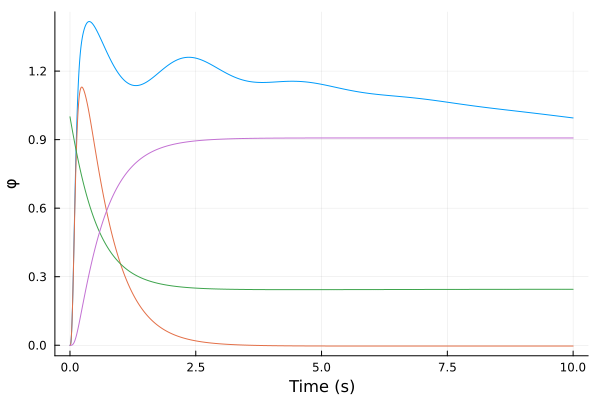

In [5466]:
a2a_fbk = P_nss_fbk[:aileron_cmd, :aileron_cmd_fwd]
a2p = P_nss[:p, :aileron_cmd]
a2p_fbk = P_nss_fbk[:p, :aileron_cmd_fwd]
a2φ = P_nss[:φ, :aileron_cmd]
a2φ_fbk = P_nss_fbk[:φ, :aileron_cmd_fwd]
step(a2p, 10) |> plot
step(a2p_fbk, 10) |> plot!
step(a2a_fbk, 10) |> plot!
step(a2φ_fbk, 10) |> plot!
# step(a2φ, 10) |> plot!

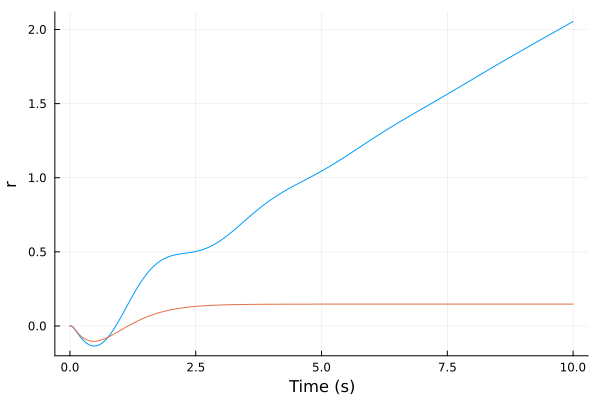

In [5467]:
a2r = P_nss[:r, :aileron_cmd]
a2r_fbk = P_nss_fbk[:r, :aileron_cmd_fwd]
step(a2r, 10) |> plot
step(a2r_fbk, 10) |> plot!

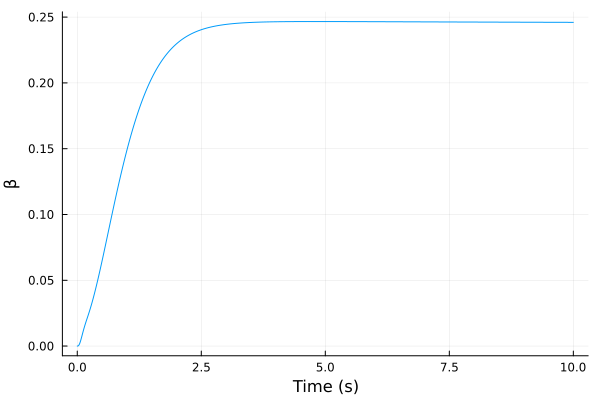

In [5468]:
a2β_fbk = P_nss_fbk[:β, :aileron_cmd_fwd]
step(a2β_fbk, 10) |> plot

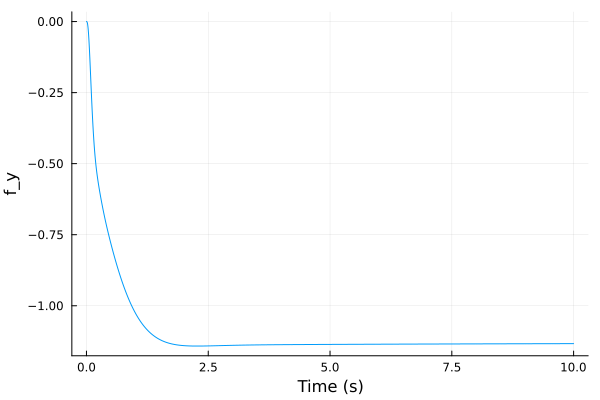

In [5469]:
a2f_fbk = P_nss_fbk[:f_y, :aileron_cmd_fwd]
step(a2f_fbk, 10) |> plot

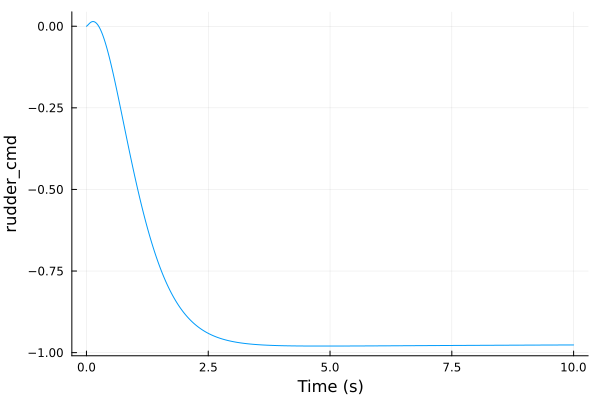

In [5470]:
ail2rud_fbk = P_nss_fbk[:rudder_cmd, :aileron_cmd_fwd]
step(ail2rud_fbk, 10) |> plot

Since bank angle is essentially a pure integral of roll rate, asymptotic equilibrium is only possible for a zero steady-state roll rate. Indeed, the closed-loop system's aileron to roll-rate step response goes to zero in the steady state. This indicates that selecting roll rate as a tracked variable will yield a (nearly) singular feedforward matrix.

For an aileron command step input, aileron command output starts at 1, and then equilibrium is achieved with a small (although not zero) value. This means that aileron command isn't a good choice for a tracked variable either, because achieving unit steady-state output in the regulated system would require very large feedforward gains and would yield an extremely high initial actuator command, well beyond 1 (at which actuator is already saturated).

What variables should then be selected for tracking? The only one we are interested in controlling explicitly is $\beta$ (or alternatively lateral specific force, $f_y$). In most cases we want to maintain $\beta = 0$ for turn coordination, but we might want to command non-zero values for cross-wind landing. If we select $\beta$ as the only command variable, we will get a 2x1 feedforward matrix which will provide a combination of aileron and rudder that achieves the desired steady-state $\beta$ (specifically, the optimal one in the least-squares sense). However, we obviously also want to retain roll control. But if we add an arbitrary external aileron command to that prescribed by the $\beta$ feedforward, we will no longer achieve the desired steady-state $\beta$ value.

Looking at the closed-loop aileron to bank angle response, we see that it starts at zero and then stabilizes at a value close to 1. This suggests that $\phi$ and $\beta$ would make for a good combination of tracked variables. For $\beta$, it is useful to add integral control. Now, once we have this MIMO system with $\phi$ and $\beta$ as inputs, we can add an external SISO loop to command roll rate, with the necessary compensation to achieve zero steady state error.

Now, we determine the feedforward gain matrix for commanding aileron and $\beta$. Following Stengel section 6.2:

In [5471]:
#define command variables
z_labels = [:φ, :β]
@assert tuple(z_labels...) === propertynames(C172FBWMCS.ZLatPhiBeta())
z_labels_sp = Symbol.(string.(z_labels) .* "_sp")

z_trim = P_lss.y0[z_labels]
n_z = length(z_labels)

F = P_lss.A
G = P_lss.B
H_x = P_lss.C[z_labels, :]
H_u = P_lss.D[z_labels, :]

A = [F G; H_x H_u]
B = inv(A)
B_12 = B[1:n_x, n_x+1:end]
B_22 = B[n_x+1:end, n_x+1:end]
C_fwd = B_22 + C_fbk * B_12
C_fwd_ss = named_ss(ss(C_fwd), u = z_labels_sp, y = u_labels_fwd)

display(z_labels)
display(H_x)
display(H_u)
display(C_fwd)

2-element Vector{Symbol}:
 :φ
 :β

2×10 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(p = 1, r = 2, φ = 3, v_x = 4, v_y = 5, β_filt = 6, ail_v = 7, ail_p = 8, rud_v = 9, rud_p = 10)
 0.0  0.0  1.0  0.0  0.0        0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0190523  0.0  0.0  0.0  0.0  0.0

2×2 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(aileron_cmd = 1, rudder_cmd = 2)
 0.0  0.0
 0.0  0.0

2×2 Matrix{Float64}:
 0.915383   0.69166
 1.40949   -5.21233

In [5472]:
connections_fwd = Pair.(C_fwd_ss.y, C_fwd_ss.y)
P_nss_SAS = connect([C_fwd_ss, P_nss_fbk], connections_fwd; w1 = z_labels_sp, z1 = P_nss_fbk.y);

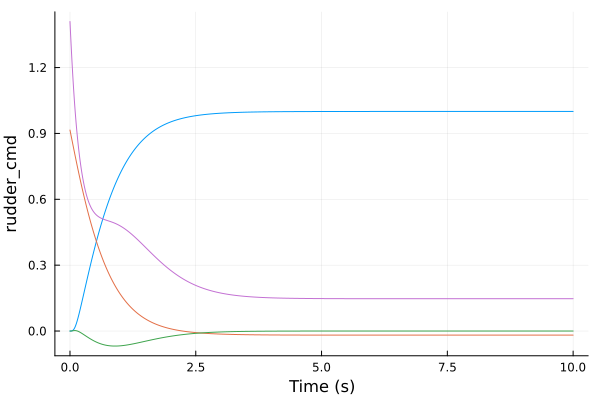

In [5473]:
φsp2φ_SAS = P_nss_SAS[:φ, :φ_sp]
φsp2β_SAS = P_nss_SAS[:β, :φ_sp]
φsp2ail_SAS = P_nss_SAS[:aileron_cmd, :φ_sp]
φsp2rud_SAS = P_nss_SAS[:rudder_cmd, :φ_sp]
step(φsp2φ_SAS, 10) |> plot
step(φsp2ail_SAS, 10) |> plot!
step(φsp2β_SAS, 10) |> plot!
step(φsp2rud_SAS, 10) |> plot!

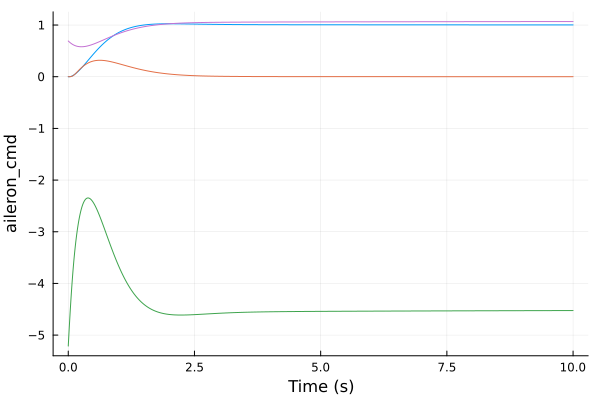

In [5474]:
βsp2β_SAS = P_nss_SAS[:β, :β_sp]
βsp2φ_SAS = P_nss_SAS[:φ, :β_sp]
βsp2rud_SAS = P_nss_SAS[:rudder_cmd, :β_sp]
βsp2ail_SAS = P_nss_SAS[:aileron_cmd, :β_sp]
step(βsp2β_SAS, 10) |> plot
step(βsp2φ_SAS, 10) |> plot!
step(βsp2rud_SAS, 10) |> plot!
step(βsp2ail_SAS, 10) |> plot!

Beautiful. Now that we know that $\phi$ and $\beta$ work well, we can repeat the design with added integral control in $\beta$.

### 1.2. Design B (Integral $\beta$ Control)

In [5475]:
#define command variables
z_labels = [:φ, :β]
@assert tuple(z_labels...) === propertynames(C172FBWMCS.ZLatPhiBeta())
z_trim = P_lss.y0[z_labels]
n_z = length(z_labels)
z_labels_sp = Symbol.(string.(z_labels) .* "_sp")

2-element Vector{Symbol}:
 :φ_sp
 :β_sp

In [5476]:
F = P_lss.A
G = P_lss.B
Hx = P_lss.C[z_labels, :]
Hu = P_lss.D[z_labels, :]
display(Hx)
display(Hu)

#define the blocks corresponding to the subset of the command variables for
#which integral compensation is required. in this case, only one of them (EAS).
#Since the resulting blocks have only one row, we get vectors, which we need to
#transpose to get the desired row matrices back.
Hx_int = Hx[:β, :]'
Hu_int = Hu[:β, :]'
n_int, _ = size(Hx_int)
display(Hx_int)
display(Hu_int)

F_aug = [F zeros(n_x, n_int); Hx_int zeros(n_int, n_int)]
G_aug = [G; Hu_int]
Hx_aug = [Hx zeros(n_z, n_int)]
Hu_aug = Hu

P_aug = ss(F_aug, G_aug, Hx_aug, Hu_aug)
controllability(F_aug, G_aug)

2×10 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(p = 1, r = 2, φ = 3, v_x = 4, v_y = 5, β_filt = 6, ail_v = 7, ail_p = 8, rud_v = 9, rud_p = 10)
 0.0  0.0  1.0  0.0  0.0        0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0190523  0.0  0.0  0.0  0.0  0.0

2×2 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(aileron_cmd = 1, rudder_cmd = 2)
 0.0  0.0
 0.0  0.0

1×10 adjoint(::ComponentVector{Float64, Vector{Float64}, Tuple{Axis{(p = 1, r = 2, φ = 3, v_x = 4, v_y = 5, β_filt = 6, ail_v = 7, ail_p = 8, rud_v = 9, rud_p = 10)}}}) with eltype Float64 with indices Base.OneTo(1)×1:1:10:
 0.0  0.0  0.0  0.0  0.0190523  0.0  0.0  0.0  0.0  0.0

1×2 adjoint(::ComponentVector{Float64, Vector{Float64}, Tuple{Axis{(aileron_cmd = 1, rudder_cmd = 2)}}}) with eltype Float64 with indices Base.OneTo(1)×1:1:2:
 0.0  0.0

(iscontrollable = true, ranks = [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11], sigma_min = [0.004504975128001959, 14.186191340660345, 14.186191340660345, 14.186191340660345, 14.186191340660345, 0.844414033745659, 0.47891757715993566, 0.47891757715993566, 0.09258051753656948, 0.025761754961287374, 0.015385191682415075])

In [5477]:
@unpack x0, u0 = P_lss
@unpack v_x, v_y = x0
v_norm = norm([v_x, v_y])

#weight matrices
Q = ComponentVector(p = 0, r = 0.1, φ = 0.15, v_x = 0/v_norm, v_y = 0.1/v_norm, β_filt = 0, ail_v = 0, ail_p = 0, rud_v = 0, rud_p = 0, ξ_β = 0.001) |> diagm
R = C172FBWMCS.ULat(aileron_cmd = 0.1, rudder_cmd = 0.05) |> diagm

#compute gain matrix
C_aug = lqr(P_aug, Q, R)

# quickly construct the closed-loop augmented system to check the resulting
# eigenvalues, we'll do the connections properly later
F_aug_cl = F_aug - G_aug * C_aug
P_aug_cl = ss(F_aug_cl, G_aug, Hx_aug, Hu_aug)

dampreport(P_aug)
dampreport(P_aug_cl)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| +0                 |  -1           |  0            |  0            |  -Inf         |
| -0.0214            |  1            |  0.0214       |  0.00341      |  46.6         |
| -0.131             |  1            |  0.131        |  0.0208       |  7.64         |
| -0.687  ±   2.69im |  0.248        |  2.77         |  0.442        |  1.46         |
| -10.5              |  1            |  10.5         |  1.67         |  0.0955       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -50                |  1            |  50           |  7.96         |  0.02         |
|        Pole        |   Damping     |   Fr

In [5478]:
#extract system state and integrator blocks from the feedback matrix
C_x = C_aug[:, 1:n_x]
C_ξ = C_aug[:, n_x+1:end]
display(C_ξ)

2×1 Matrix{Float64}:
  0.038027789616978405
 -0.13079669119310464

In [5479]:
#some useful signal labels
u_labels_fbk = Symbol.(string.(u_labels) .* "_fbk")
u_labels_fwd = Symbol.(string.(u_labels) .* "_fwd")
u_labels_sum = Symbol.(string.(u_labels) .* "_sum")
u_labels_int_u = Symbol.(string.(u_labels) .* "_int_u")
u_labels_int = Symbol.(string.(u_labels) .* "_int")
u_labels_ξ = Symbol.(string.(u_labels) .* "_ξ")

z_labels_sp = Symbol.(string.(z_labels) .* "_sp")
z_labels_sp1 = Symbol.(string.(z_labels) .* "_sp1")
z_labels_sp2 = Symbol.(string.(z_labels) .* "_sp2")
z_labels_err = Symbol.(string.(z_labels) .* "_err")
z_labels_sum = Symbol.(string.(z_labels) .* "_sum")
z_labels_sp_fwd = Symbol.(string.(z_labels) .* "_sp_fwd")
z_labels_sp_sum = Symbol.(string.(z_labels) .* "_sp_sum")

A = [F G; Hx Hu]
B = inv(A)
B_12 = B[1:n_x, n_x+1:end]
B_22 = B[n_x+1:end, n_x+1:end]

C_fbk = C_x
C_fbk_ss = named_ss(ss(C_fbk), u = x_labels, y = u_labels_fbk)

C_fwd = B_22 + C_x * B_12
C_fwd_ss = named_ss(ss(C_fwd), u = z_labels_sp_fwd, y = u_labels_fwd)

#the integral gain matrix is constructed by padding C_ξ with zeros in those
#columns corresponding to command variables without integral compensation
C_int = ComponentMatrix(zeros(n_u, n_z), Axis(u_labels), Axis(z_labels))
C_int[:, :β] .= C_ξ
C_int_ss = named_ss(ss(C_int), u = z_labels_err, y = u_labels_int_u)

int_ss = named_ss(ss(tf(1, [1,0])) .* I(2),
                    x = u_labels_ξ,
                    u = u_labels_int_u,
                    y = u_labels_int);

# display(C_fbk_ss)
# display(C_fwd_ss)
# display(C_int_ss)
# display(int_ss)

φ_err_sum = sumblock("φ_err = φ_sum - φ_sp_sum")
β_err_sum = sumblock("β_err = β_sum - β_sp_sum")

aileron_cmd_sum = sumblock("aileron_cmd_sum = aileron_cmd_fwd - aileron_cmd_fbk - aileron_cmd_int")
rudder_cmd_sum = sumblock("rudder_cmd_sum = rudder_cmd_fwd - rudder_cmd_fbk - rudder_cmd_int")

φ_sp_splitter = splitter(:φ_sp, 2)
β_sp_splitter = splitter(:β_sp, 2)

connections = vcat(
    Pair.(x_labels, x_labels),
    Pair.(z_labels, z_labels_sum),
    Pair.(z_labels_sp1, z_labels_sp_sum),
    Pair.(z_labels_sp2, z_labels_sp_fwd),
    Pair.(z_labels_err, z_labels_err),
    Pair.(u_labels_sum, u_labels),
    Pair.(u_labels_fwd, u_labels_fwd),
    Pair.(u_labels_fbk, u_labels_fbk),
    Pair.(u_labels_int, u_labels_int),
    Pair.(u_labels_int_u, u_labels_int_u),
    )

P_nss_φβ = connect([P_nss, int_ss, C_fwd_ss, C_fbk_ss, C_int_ss,
                    φ_err_sum, β_err_sum,
                    aileron_cmd_sum, rudder_cmd_sum,
                    φ_sp_splitter, β_sp_splitter], connections;
                    w1 = z_labels_sp, z1 = vcat(y_labels))

dampreport(P_nss_φβ)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -1.4e-16           |  1            |  1.4e-16      |  2.22e-17     |  7.16e+15     |
| -0.0125            |  1            |  0.0125       |  0.00199      |  79.8         |
| -0.132             |  1            |  0.132        |  0.0211       |  7.56         |
| -1.67              |  1            |  1.67         |  0.265        |  0.6          |
| -2.58   ±   3.42im |  0.603        |  4.28         |  0.681        |  0.388        |
| -10.5              |  1            |  10.5         |  1.67         |  0.0954       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.2im |  0.599        |  31.4         |  5            |  0.0531       |
| -50                |  1            |  50 

┌ Warning: Connecting single output to multiple inputs Y1=Union{Nothing, Int64}[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 3, 12, 28, 30, 29, 31, 24, 25, 26, 27, 18, 19, 20, 21, 16, 17, 22, 23]
└ @ ControlSystemsBase C:\Users\Miguel\.julia\packages\ControlSystemsBase\TuYDk\src\connections.jl:327


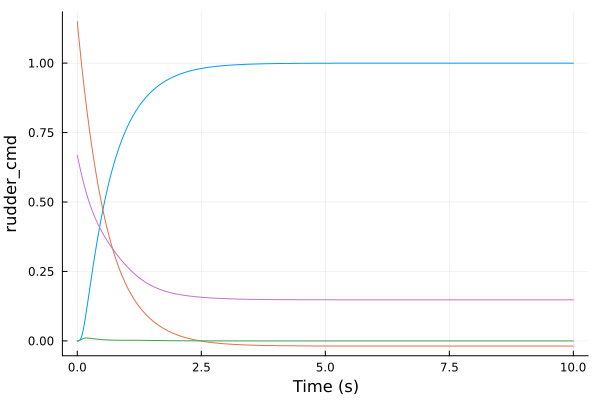

In [5480]:
φsp2φ_φβ = P_nss_φβ[:φ, :φ_sp]
φsp2β_φβ = P_nss_φβ[:β, :φ_sp]
φsp2ail_φβ = P_nss_φβ[:aileron_cmd, :φ_sp]
φsp2rud_φβ = P_nss_φβ[:rudder_cmd, :φ_sp]
step(φsp2φ_φβ, 10) |> plot
step(φsp2ail_φβ, 10) |> plot!
step(φsp2β_φβ, 10) |> plot!
step(φsp2rud_φβ, 10) |> plot!

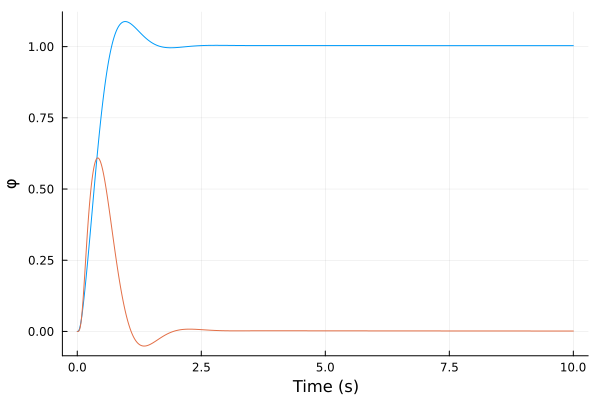

In [5481]:
βsp2β_φβ = P_nss_φβ[:β, :β_sp]
βsp2φ_φβ = P_nss_φβ[:φ, :β_sp]
βsp2rud_φβ = P_nss_φβ[:rudder_cmd, :β_sp]
βsp2ail_φβ = P_nss_φβ[:aileron_cmd, :β_sp]
step(βsp2β_φβ, 10) |> plot
step(βsp2φ_φβ, 10) |> plot!
# step(βsp2rud_φβ, 10) |> plot!
# step(βsp2ail_φβ, 10) |> plot!

## 2. Roll Rate Control Augmentation

We now design a roll rate CAS on top of the plant with $\phi$ and $\beta$ tracking. This will be a SISO loop connected to the $\phi_{sp}$ input. That is, we will provide roll rate tracking via the bank angle set point. Clearly, one or more integrators will be needed.

In [5482]:
P_φ2p = P_nss_φβ[:p, :φ_sp];

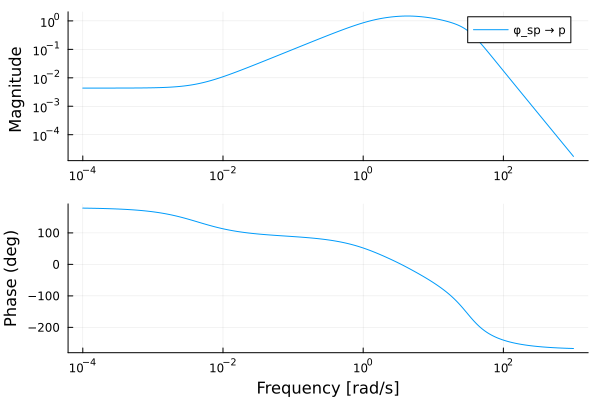

In [5483]:
bodeplot(P_φ2p)

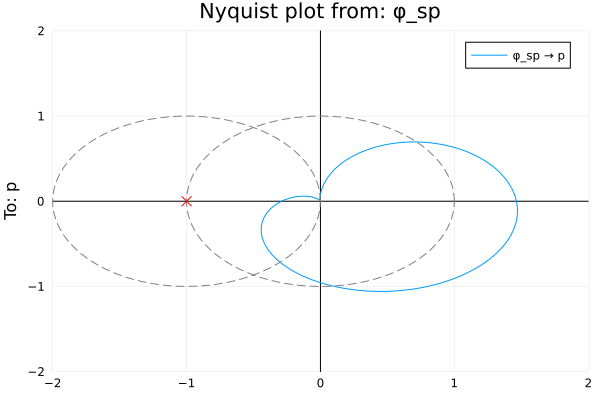

In [5484]:
nyquistplot(P_φ2p; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

In [5485]:
p2φ_int = tf(1, [1, 0]) |> ss
P_p2φ_opt = series(p2φ_int, ss(P_φ2p))

t_sim_p2φ = 10
lower_bounds = Params(; k_p = 0.1, k_i = 0.0, k_d = 0.0, τ_f = 0.01)
upper_bounds = Params(; k_p = 10.0, k_i = 35.0, k_d = 1.5, τ_f = 0.01)
settings = Settings(; t_sim = t_sim_p2φ, lower_bounds, upper_bounds)
weights = Metrics(; Ms = 1, ∫e = 10, ef = 2, ∫u = 0.1, up = 0.00)
params_0 = Params(; k_p = 1.5, k_i = 3, k_d = 0.1, τ_f = 0.01)

p2φ_results = optimize_PID(P_p2φ_opt; params_0, settings, weights, global_search = false)

@unpack k_p, k_i, k_d, T_i, T_d = p2φ_results.params
@unpack k_p, k_i, k_d, T_i, T_d = p2φ_results.params
@show k_p, k_i, k_d, T_i, T_d
@show p2φ_results.metrics
@show p2φ_results.exit_flag

(k_p, k_i, k_d, T_i, T_d) = (2.6800336672755627, 4.303358725828497, 0.17374780583301153, 0.6227771928912558, 0.0648304564060339)
p2φ_results.metrics = [1.211177264457836, 0.02506456692608213, 0.0010529650221640097, 0.0727482825381748, 19.054814250576715]
p2φ_results.exit_flag = :ROUNDOFF_LIMITED


:ROUNDOFF_LIMITED

In [5486]:
p2φ_PID = build_PID(p2φ_results.params)
C_p2φ = named_ss(series(p2φ_int, p2φ_PID), :C_p2φ; u = :p_err, y = :φ_sp)

C_p2φ: NamedStateSpace{Continuous, Float64}
A = 
 0.0     4.0   0.0
 0.0  -100.0  32.0
 0.0     0.0   0.0
B = 
 0.0
 0.0
 1.0
C = 
 3.361999004553513  -54.16170936263396  20.054814250576715
D = 
 0.0

Continuous-time state-space model
With state  names: C_p2φx1 C_p2φx2 C_p2φx3
     input  names: p_err
     output names: φ_sp


StepInfo:
Initial value:     0.000
Final value:       0.999
Step size:         0.999
Peak:              1.004
Peak time:         1.240 s
Overshoot:          0.52 %
Undershoot:         0.00 %
Settling time:     0.664 s
Rise time:         0.382 s


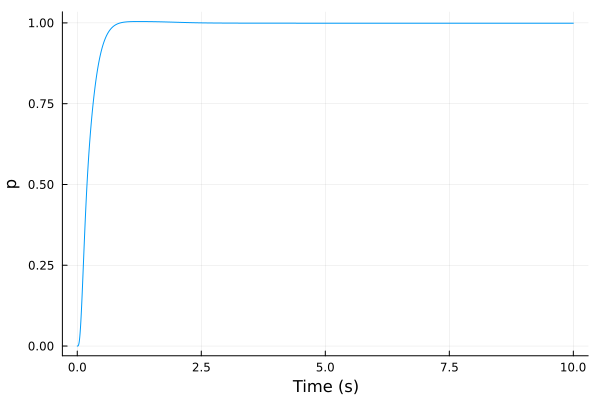

In [5487]:
#steady-state error for a unit step input, now zero
L_p2φ = series(C_p2φ, P_φ2p)

T_p2φ = output_comp_sensitivity(P_φ2p, C_p2φ) #this is the closed loop transfer function
T_p2φ_step = step(T_p2φ, t_sim_p2φ)
stepinfo(T_p2φ_step) |> display
T_p2φ_step |> plot

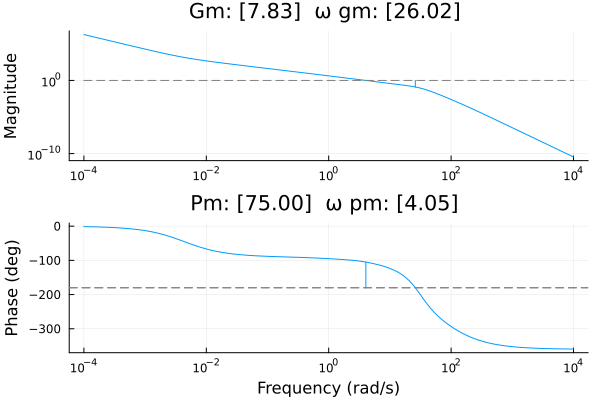

In [5488]:
marginplot(L_p2φ)

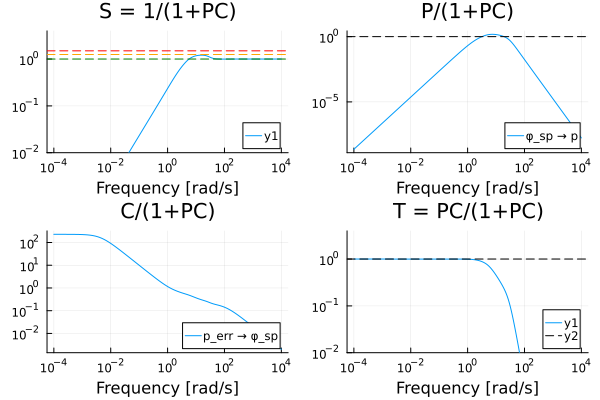

In [5489]:
gangoffourplot(P_φ2p, C_p2φ)

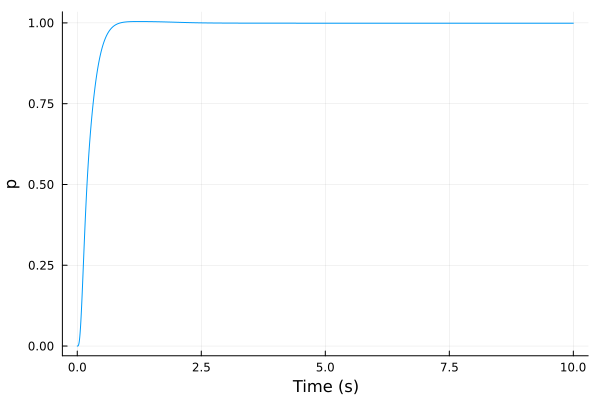

In [5490]:
p2φ_sum = sumblock("p_err = p_sp - p")
P_nss_pβ = connect([p2φ_sum, C_p2φ, P_nss_φβ], [:p_err=>:p_err, :p=>:p, :φ_sp=>:φ_sp], w1 = [:p_sp, :β_sp], z1 = P_nss_φβ.y)

#verify we get the same response as with the SISO closed loop
psp2p = P_nss_pβ[:p, :p_sp]
step(psp2p, t_sim_p2φ) |> plot

#and we see that the response matches that of the SISO design